In [1]:
# importing the libraries
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import glob
from PIL import Image, ExifTags
import colorsys
import random
import pylab
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim
from tqdm.notebook import tqdm
import os
import random
from IPython import display
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore
from ignite.contrib.handlers import ProgressBar
import warnings

warnings.filterwarnings("ignore")

def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    plt.imshow(grid.clip(0,1))
    plt.axis('off')
    plt.show()
    plt.axis('off')
    

In [2]:
### Global parameters
n_epochs=50
batch_size=64
image_size = 128
lr=1e-4
z_dim=200
device='cuda' #GPU
damage = 'nodmg'
tag=f'WGAN_{damage}'
data_path=f'../data/onlycracks/train/{damage}'

### W-GAN
crit_cycles=5
show_step=100
save_step=100

In [3]:
# generator model
class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim=z_dim

        self.gen = nn.Sequential(
                ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
                ## Calculating new width and height: (n-1)*stride -2*padding +ks
                ## n = width or height
                ## ks = kernel size
                ## we begin with a 1x1 image with z_dim number of channels (200)
                nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
                nn.BatchNorm2d(d_dim*32),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
                nn.BatchNorm2d(d_dim*16),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
                #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
                nn.BatchNorm2d(d_dim*8),
                nn.ReLU(True),

                nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
                nn.BatchNorm2d(d_dim*4),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
                nn.BatchNorm2d(d_dim*2),
                nn.ReLU(True),            

                nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
                nn.Tanh() ### produce result in the range from -1 to 1
        )


    def forward(self, noise):
        x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 x 200 x 1 x 1
        return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200



In [4]:
## critic model

class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()

        self.crit = nn.Sequential(
          # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
          ## New width and height: # (n+2*pad-ks)//stride +1
          nn.Conv2d(3, d_dim, 4, 2, 1), #(n+2*pad-ks)//stride +1 = (128+2*1-4)//2+1=64x64 (ch: 3,16)
          nn.InstanceNorm2d(d_dim), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), ## 32x32 (ch: 16, 32)
          nn.InstanceNorm2d(d_dim*2), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), ## 16x16 (ch: 32, 64)
          nn.InstanceNorm2d(d_dim*4), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), ## 8x8 (ch: 64, 128)
          nn.InstanceNorm2d(d_dim*8), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), ## 4x4 (ch: 128, 256)
          nn.InstanceNorm2d(d_dim*16), 
          nn.LeakyReLU(0.2),

          nn.Conv2d(d_dim*16, 1, 4, 1, 0), #(n+2*pad-ks)//stride +1=(4+2*0-4)//1+1= 1X1 (ch: 256,1)

        )


    def forward(self, image):
        # image: 128 x 3 x 128 x 128
        crit_pred = self.crit(image) # 128 x 1 x 1 x 1
        return crit_pred.view(len(crit_pred),-1) ## 128 x 1  
  

# Optimizers

In [5]:
gen = Generator(z_dim=200).to(device)
crit = Critic().to(device)
# Different optimizer options for generator and discriminator
crit_opt = optim.Adam(crit.parameters(), lr=1e-4, betas=(0.5, 0.9))
gen_opt = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))

# DataLoader

In [6]:
## optional, init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias,0)

    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias,0)

In [7]:
class image_loader(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=''):
        'Initialization'
        self.transform = transform
        self.image_paths = glob.glob(data_path+'/*.jpg')
        if train:
            self.image_paths = self.image_paths[0:int(0.9*len(self.image_paths))]
        else:
            self.image_paths = self.image_paths[int(0.9*len(self.image_paths)):]
        self.labels_dict = {damage:0}
        self.inv_labels_dict = {v: k for k, v in self.labels_dict.items()}
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        X = self.transform(image)
        y = self.labels_dict[image_path.split("/")[-2]]
        
        return X, y


train_transform = transforms.Compose([transforms.Resize((image_size, image_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                    )

trainset = image_loader(train=True, transform=train_transform,
                        data_path=data_path)
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,
                              num_workers=12, drop_last=True)

testset = image_loader(train=False, transform=train_transform,
                       data_path=data_path)
test_dataloader = DataLoader(testset, batch_size=batch_size,
                             num_workers=12, drop_last=True)

Train set length:  2586
Test set length:  288


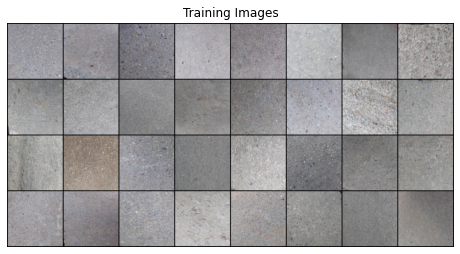

In [8]:
print("Train set length: ", len(train_dataloader.dataset))
print("Test set length: ", len(test_dataloader.dataset))


real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Evaluation metrics

In [9]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])

In [10]:
## gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
    mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
    mix_scores = crit(mix_images) # 128 x 1

    gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
    )[0] # 128 x 3 x 128 x 128

    gradient = gradient.view(len(gradient), -1)   # 128 x 49152
    gradient_norm = gradient.norm(2, dim=1) 
    gp = gamma * ((gradient_norm-1)**2).mean()

    return gp

## Interpolate dataset images to 299x299x3 to be able to work with IS and FID prebuilt functions
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

## Apply interpolation to fake and real batch images
def evaluation_step(Engine, batch):
    with torch.no_grad():
        noise = gen_noise(len(batch[0]), z_dim)
        gen.eval()
        fake_batch = gen(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [11]:
evaluator = Engine(evaluation_step)
is_metric.attach(evaluator, "is")
fid_metric.attach(evaluator, "fid")

# Training

In [12]:
def training_losses(gen_losses, crit_losses, cur_step, show_step):
    gen_mean=sum(gen_losses[-show_step:]) / show_step
    crit_mean = sum(crit_losses[-show_step:]) / show_step
    print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
    

In [13]:
def evaluate_fid_is():
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [14]:
## Save and load checkpoints

if not os.path.exists(f'../info/{tag}/'):
    os.mkdir(f'../info/{tag}/')
root_path=f'../info/{tag}/'

def save_checkpoint(name):
    torch.save({
      'epoch': epoch,
      'gen_losses': gen_losses,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],        
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()      
    }, f"{root_path}G-{name}.pkl")

    torch.save({
      'epoch': epoch,
      'crit_losses': crit_losses,
      'fids': evaluator.state.metrics['fid'],
      'iss': evaluator.state.metrics['is'],
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()      
    }, f"{root_path}C-{name}.pkl")
  
    print("Saved checkpoint")

def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}G-{name}.pkl")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}C-{name}.pkl")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint")

#load_checkpoint('final-wgan-noinit')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.030448
*    IS : 1.081422


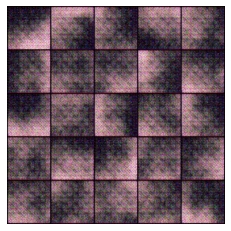

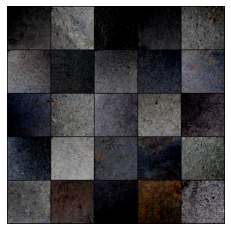

Epoch: 2: Step 100: Generator loss: 5.671954710781574, critic loss: -2.3709327948689465
Saving checkpoint:  100 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.089283
*    IS : 1.222944


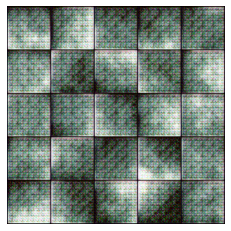

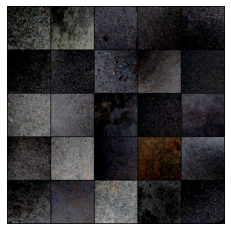

Epoch: 5: Step 200: Generator loss: 7.741517505645752, critic loss: -4.6830278518199915
Saving checkpoint:  200 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.030852
*    IS : 1.235092


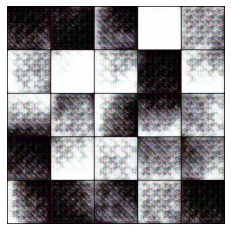

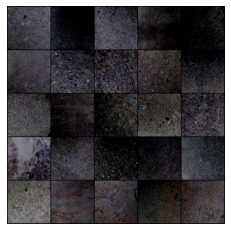

Epoch: 7: Step 300: Generator loss: 8.718612852096557, critic loss: -5.563345259666444
Saving checkpoint:  300 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.032413
*    IS : 1.297312


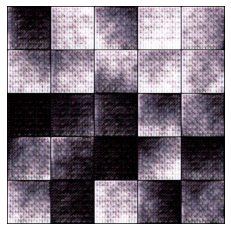

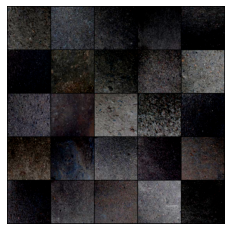

Epoch: 10: Step 400: Generator loss: 6.833688497543335, critic loss: -4.8197598862648
Saving checkpoint:  400 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.046764
*    IS : 1.485250


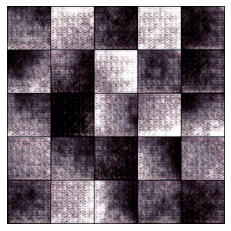

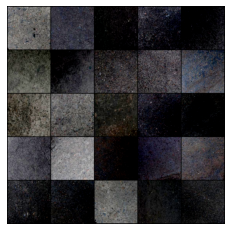

Epoch: 12: Step 500: Generator loss: 6.205464293956757, critic loss: -4.361383348464965
Saving checkpoint:  500 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.052877
*    IS : 1.406602


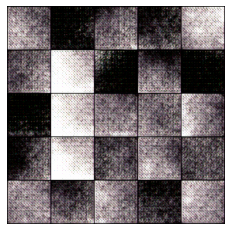

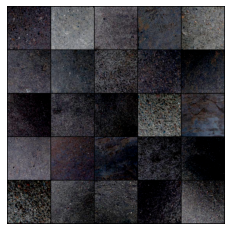

Epoch: 15: Step 600: Generator loss: 5.33358204126358, critic loss: -3.905309087991717
Saving checkpoint:  600 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.025042
*    IS : 1.244938


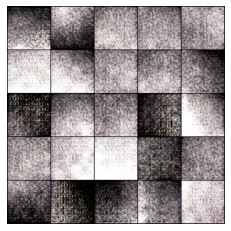

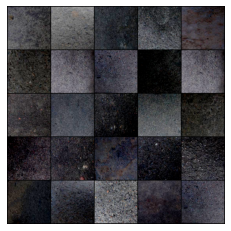

Epoch: 17: Step 700: Generator loss: 4.454583015441894, critic loss: -3.4635578284263606
Saving checkpoint:  700 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.025361
*    IS : 1.199504


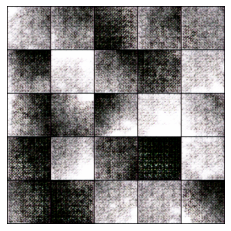

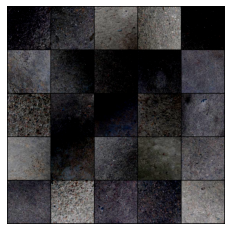

Epoch: 20: Step 800: Generator loss: 3.7282115149497987, critic loss: -2.8526400201320645
Saving checkpoint:  800 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.028316
*    IS : 1.314036


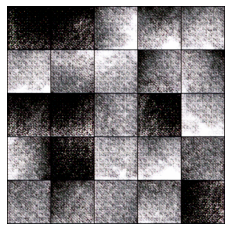

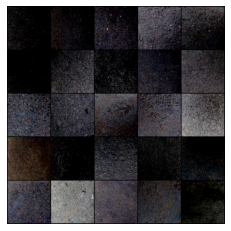

Epoch: 22: Step 900: Generator loss: 3.20622514128685, critic loss: -2.586035981178284
Saving checkpoint:  900 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.023678
*    IS : 1.188142


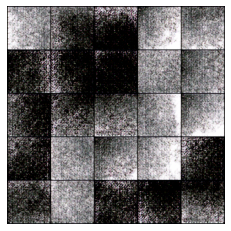

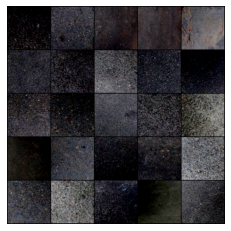

Epoch: 25: Step 1000: Generator loss: 2.758549639284611, critic loss: -2.2723534768819813
Saving checkpoint:  1000 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.021472
*    IS : 1.202503


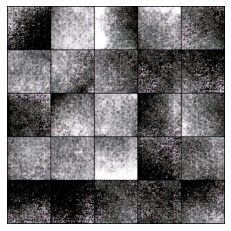

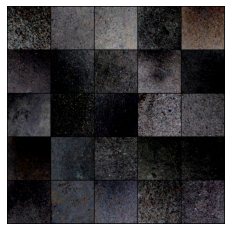

Epoch: 27: Step 1100: Generator loss: 2.272963970862329, critic loss: -1.9543090245723729
Saving checkpoint:  1100 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.021056
*    IS : 1.195334


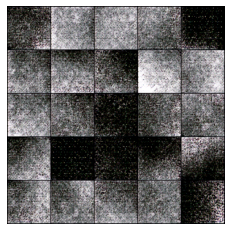

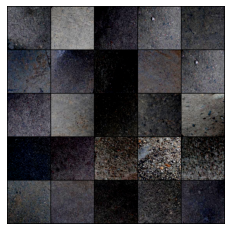

Epoch: 30: Step 1200: Generator loss: 2.154469380527735, critic loss: -1.8906814850568778
Saving checkpoint:  1200 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.021981
*    IS : 1.225874


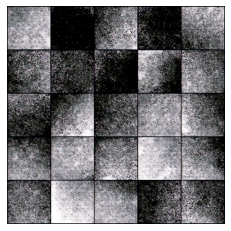

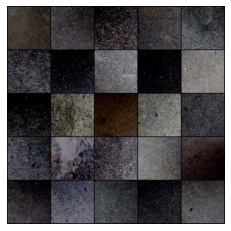

Epoch: 32: Step 1300: Generator loss: 2.082203302010894, critic loss: -1.9390321000814437
Saving checkpoint:  1300 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.023195
*    IS : 1.182409


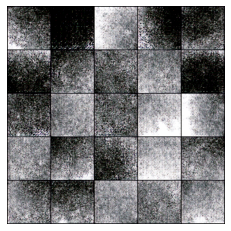

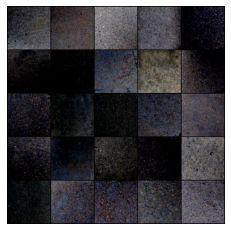

Epoch: 35: Step 1400: Generator loss: 1.8867390464991332, critic loss: -2.006214405179024
Saving checkpoint:  1400 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.022176
*    IS : 1.185119


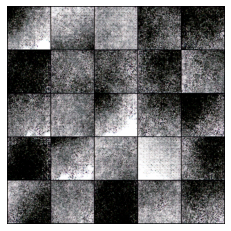

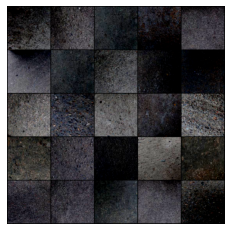

Epoch: 37: Step 1500: Generator loss: 1.91085979051888, critic loss: -2.205105208039284
Saving checkpoint:  1500 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.022405
*    IS : 1.168365


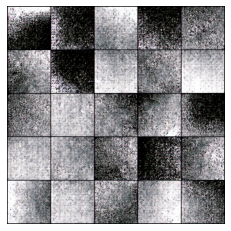

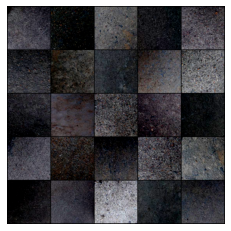

Epoch: 40: Step 1600: Generator loss: 1.7097486381232738, critic loss: -2.2621338047981254
Saving checkpoint:  1600 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.021226
*    IS : 1.155590


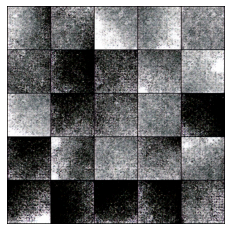

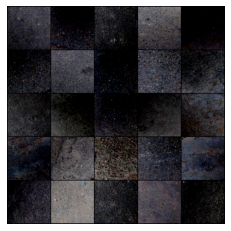

Epoch: 42: Step 1700: Generator loss: 1.6044630479812623, critic loss: -2.3763190507888785
Saving checkpoint:  1700 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.021104
*    IS : 1.175407


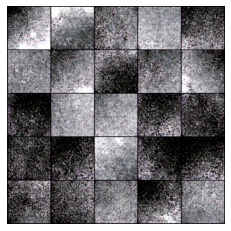

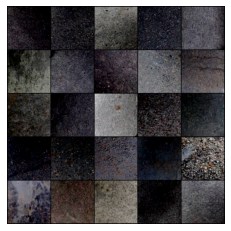

Epoch: 45: Step 1800: Generator loss: 1.7402845093607902, critic loss: -2.482714771509171
Saving checkpoint:  1800 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

*   FID : 0.022134
*    IS : 1.166227


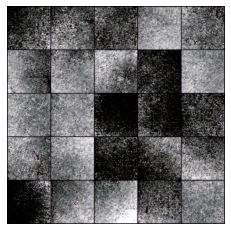

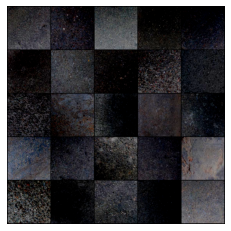

Epoch: 47: Step 1900: Generator loss: 1.566579043418169, critic loss: -2.6511178047657014
Saving checkpoint:  1900 100
Saved checkpoint


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

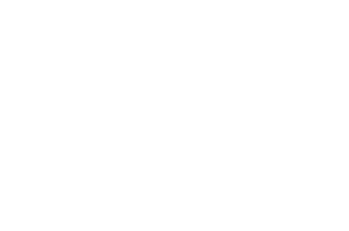

In [15]:
## Training loop 
gen_losses=[]
crit_losses=[]
cur_step=0
for epoch in range(n_epochs):
    for real, _ in tqdm(train_dataloader):
        cur_bs= len(real) #128
        real=real.to(device)

        ### CRITIC
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise=gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha=torch.rand(len(real),1,1,1,device=device, requires_grad=True) # 128 x 1 x 1 x 1
            gp = get_gp(real, fake.detach(), crit, alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

            mean_crit_loss+=crit_loss.item() / crit_cycles

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses+=[mean_crit_loss]

        ### GENERATOR
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses+=[gen_loss.item()]

        ### STATS  
        if (cur_step % show_step == 0 and cur_step > 0):
            evaluate_fid_is()
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')
            training_losses(gen_losses, crit_losses, cur_step, show_step)
            
            print("Saving checkpoint: ", cur_step, save_step)
            save_checkpoint("latest")

        cur_step+=1


# Generate Dout data

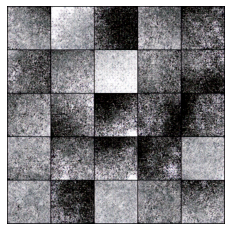

In [16]:
def show(tensor, num=25, wandbactive=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)

    plt.imshow(grid.clip(0,1))
    plt.axis('off')
    plt.show()
    
num = 128
noise = gen_noise(num, z_dim)
fake = gen(noise)
show(fake)

In [17]:
def save_ganimages(damage, path, num):
    for i in range(num):
        image_path = os.path.join(path, damage, f'GAN_{i}.jpg') 
        noise = gen_noise(1,z_dim)
        fake = gen(noise)
        fake = fake[0].detach().cpu()
        fake = fake.permute(1,2,0)
        fake = Image.fromarray(np.uint8(fake*255))
        fake.save(image_path)

path = '../data/WGAN_Din'
save_ganimages(damage, path, 2000)